# Importación de las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date,timedelta
import plotly.express as px

# Lectura de las base de datos

Se esta toamando la base de datos publicada en Open Data Colombia por la INS la cual se actualizara con los datos más recientes cada vez que se ejecute el código.

In [2]:
covid = pd.read_csv("https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv", sep=",", encoding='utf-8')
covid.head()

C:\Users\ESTEBAN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10,12,14,16,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ID de caso,Fecha de notificación,Código DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,...,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Tipo recuperación,Codigo departamento,Codigo pais,Pertenencia etnica,Nombre grupo etnico
0,1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,...,2020-02-27T00:00:00.000,NaN,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000,PCR,11,380.0,Otro,NaN
1,2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,...,2020-03-04T00:00:00.000,NaN,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000,PCR,76,724.0,Otro,NaN
2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,...,2020-02-29T00:00:00.000,NaN,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000,PCR,5,724.0,Otro,NaN
3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,...,2020-03-06T00:00:00.000,NaN,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN
4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,...,2020-03-08T00:00:00.000,NaN,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000,PCR,5,NaN,Otro,NaN


La base de datos contiene la información individual por caso, donde cada caso es un caso confirmado, además contiene la información de la fecha de recuperación para las personas ya recuperadas, la fechad e muerte para las personas fallecidas, y las fechas de inicio de síntomas, fecha de diagnostico y la fecha en que se notifico el caso.

In [3]:
# Dimensión de las base de datos
covid.shape

(658456, 21)

### Depuración de los datos

Se crea una copia de la base de daros original descargada y a esta se le aplican las siguientes acciones:
- Eliminación de caracteres especiales como tildes, vergulillas, dieresis, etc.
- LLevar a formato fecha de python las columnas con fecha de las base de datos.
- Eliminar espacios en las valores de las columnas.
- Se estandariza los valores de la columna "Atnecion"
- Los valores que en la columna "Atencion" aparecen en NaN quieren decir que no se tiene información de si estan recuperado, muertos, etc., por lo tanto estos fueron clasificados como Fallecidos, quienes tiene fecha de muerte, y Activos, quienes no la tienen.

In [4]:
#Creamos una copia del dataset
df = covid.copy()
#Función para eliminar caracteres especiales
import unicodedata
def car_espe(lista):
    return(unicodedata.normalize('NFKD', lista).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

#Se eliminan caracteres especiales y espacios en atras y adelante de los encabezados
df.columns = [car_espe(h).strip() for h in df.columns]

#Cambio a formato de fecha Fecha de notificacion
df['Fecha de notificacion'] = pd.to_datetime(df['Fecha de notificacion'])
df['Fecha de muerte'] = pd.to_datetime(df['Fecha de muerte'])
df['Fecha recuperado'] = pd.to_datetime(df['Fecha recuperado'])

df = df.sort_values('Fecha de notificacion')

# Los valores con "nan" en la columna atencio corresponden para los casos de los cuales no se tiene información
#pero son tomados como casos confirmados por lo tanto se tomaran como casos activos
#Ajuste de los nan en atencion por activos o fallecidos
for i in df.index:
    if pd.isnull(df['atencion'][i]):
        if pd.isnull(df['Fecha de muerte'][i]):
            df['atencion'][i] = 'Activo'
        else:
            df['atencion'][i] = 'Fallecido'

#Eliminar caracteres especiales del nombre de la ciudad y del departamento
df['Ciudad de ubicacion'] = [car_espe(f).strip() for f in df['Ciudad de ubicacion']]
df['Departamento o Distrito'] = [car_espe(f).strip() for f in df['Departamento o Distrito']]

df['atencion'] = [f.capitalize().strip() for f in df['atencion']]

df = df[['Fecha de notificacion','Fecha de muerte','Fecha recuperado','Ciudad de ubicacion','atencion','Edad','Sexo']]
df.columns = ['fecha_notificacion','fecha_muerte','fecha_recuperado','ciudad','atencion','edad','sexo']
df.tail()

<ipython-input-4-ed480cd7a986>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atencion'][i] = 'Fallecido'
<ipython-input-4-ed480cd7a986>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atencion'][i] = 'Activo'


,fecha_notificacion,fecha_muerte,fecha_recuperado,ciudad,atencion,edad,sexo
653165,2020-09-05,NaT,NaT,Bogota D.C.,Casa,24,M
653166,2020-09-05,NaT,NaT,Bogota D.C.,Casa,38,M
653169,2020-09-05,NaT,NaT,Bogota D.C.,Casa,19,F
653167,2020-09-05,NaT,NaT,Bogota D.C.,Casa,22,F
651132,2020-09-05,NaT,NaT,Campoalegre,Casa,23,F


###### Histogramas de frecuencia del número de casos confirmados para Colombia y sus 5 principales ciudades

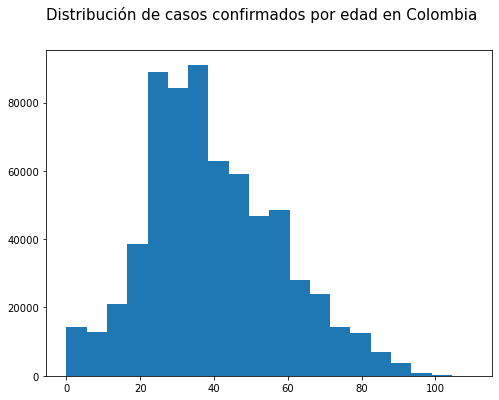

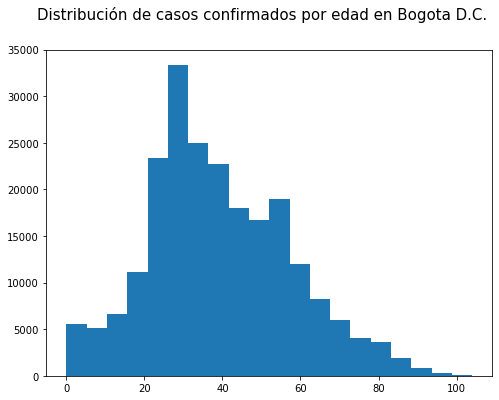

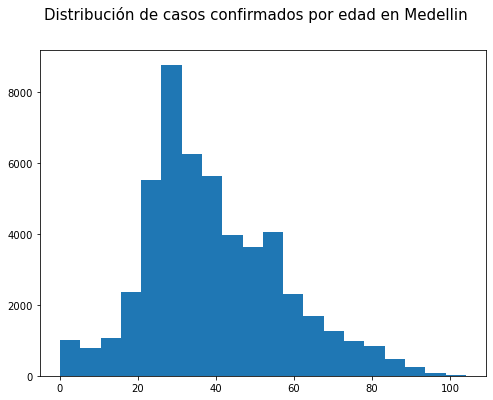

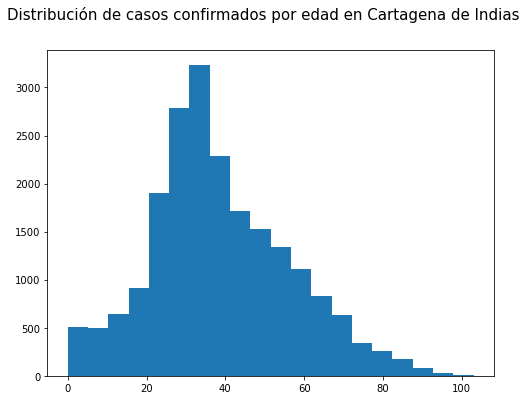

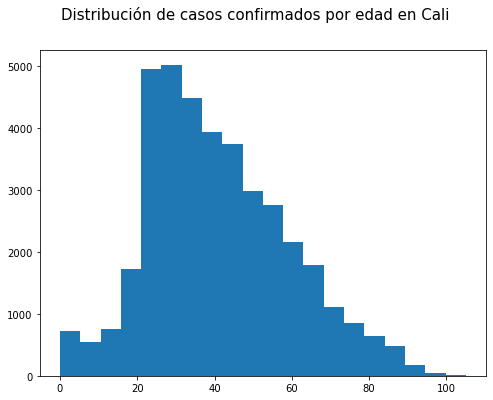

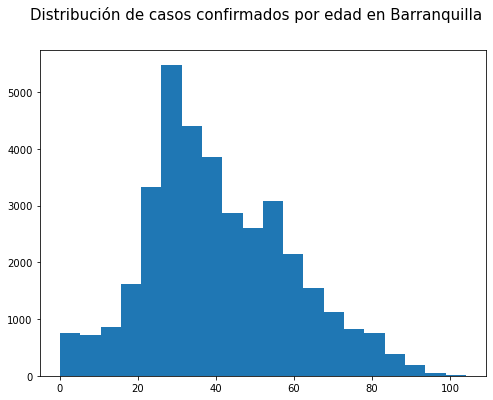

In [5]:
#Las graficas quedan guardas en la ruta figuras/histogramas_edad/
ciudades = ['Colombia', 'Bogota D.C.', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
for i in ciudades:
    if i == "Colombia":
        ciu = df.copy()
    else:
        ciu = df[df['ciudad'] == i]
        
    fig, ax = plt.subplots(1, figsize=(8, 6))
    fig.suptitle('Distribución de casos confirmados por edad en ' + str(i), fontsize=15)
    ax.hist(ciu['edad'], bins=20)
    fig = plt.savefig('figuras/histogramas_edad/' + 'edad_' + str(i) + '.png')

# Contrucción del Modelo SIRM a partir de los datos

<p>La función que se define contruye la una tabla con el número de infectados para cada días con una media movil de 7 días, esto con el fin de suavisar un poco la curva de los casoso confirmados. Este procedimiento se realiza de la misma forma para los recuperados y los fallecidos. Además contruye el numero de casos activos por días y el número de personas suceptibles al contagio. También hace el calculo del beta (tasa de infección), gamma (tasa de recuperación) y delta (tasa de muestre) para cada uno de los días; a partir de estos valores es que se hará el pronostico.</p>

<p>La función toma como entradas un DataFrame y el nombre de la ciudad para la cual se va a hacer la contrucción</p>


In [23]:
# Poblacion de las Colombia y las ciudades que se van a modelar
poblacion = {'Colombia': 50882884, 'Bogota D.C.': 7743955, 'Medellin': 2933094, 'Cartagena de Indias': 1028736,
             'Cali': 2497562, 'Barranquilla': 1243113}

#Ingresa el DataFrame del covid ( definido como df) y el entre comillas el nombre de la ciudad a calcular
def data_sirm(df, ciudad):
    
    #Filtro de la ciudad a revisar
    if ciudad == "Colombia":
        df1 = df.copy()
    else:
        df1 = df[df['ciudad'] == ciudad]

    #Dataframe predefinido con el listado de fechas
    df_fecha = pd.DataFrame(np.unique(df1['fecha_notificacion']))
    df_fecha.columns = ['fecha']    

    # Calculo del numero de infectados por día
    df_sirm = df1.groupby(['fecha_notificacion'], as_index=False)['atencion'].count()
    df_sirm.columns = ['fecha','infectados']
    # Calculo del promedio movil de 7 dias del numero de infectados por dia y el acumulado
    df_sirm['infectados'] = df_sirm['infectados'].rolling(7).mean()
    df_sirm = df_sirm.dropna()
    df_sirm['infectados_acum'] = df_sirm['infectados'].cumsum()

    # Calculo del numero de infectados resuperados por dia, el promedio movil de 7 dias y el acumulado
    df_recu = df1[df1['atencion'] == 'Recuperado'].groupby(['fecha_recuperado'], as_index=False)['atencion'].count()
    df_recu.columns = ['fecha','recuperados']
    df_recu = df_fecha.merge(df_recu, on='fecha', how='left')
    df_recu['recuperados'].fillna(0, inplace=True) #Reemplza los NaN por 0
    df_recu['recuperados'] = df_recu['recuperados'].rolling(7).mean() #promedio movil de 7 dias
    df_recu['recuperados_acum'] = df_recu['recuperados'].cumsum() #acumulado

    # Concatenando la infroamción de recuperado en la base de df_sirm
    df_sirm = df_sirm.merge(df_recu, on='fecha', how='left')

    # Calculo del numero de infectados muertos por dia, el promedio movil de 7 dias y el acumulado
    df_muerto = df1[df1['atencion'] == 'Fallecido'].groupby(['fecha_muerte'], as_index=False)['atencion'].count()
    df_muerto.columns = ['fecha','fallecidos']
    df_muerto = df_fecha.merge(df_muerto, on='fecha', how='left')
    df_muerto['fallecidos'].fillna(0, inplace=True) #Reemplza los NaN por 0
    df_muerto['fallecidos'] = df_muerto['fallecidos'].rolling(7).mean() #promedio movil de 7 dias
    df_muerto['fallecidos_acum'] = df_muerto['fallecidos'].cumsum() #acumulado

    # Concatenando la infroamción de fallecidos en la base de df_sirm
    df_sirm = df_sirm.merge(df_muerto, on='fecha', how='left')
    
    # Obtencion de los betas, gammas y deltas
    N = poblacion.get(ciudad) #Obtiene el el total de la poblacion de acuerdo a la ciudad definida en el diccionario
    
    # N = Total de la poblacion
    # S = Suceptibles
    # I = Infectados
    # R = Recuperados
    # F = Fallecidos
    # A = Infectados Activos
    df_sirm['activos'] = df_sirm['suceptibles'] = df_sirm['beta'] = df_sirm['gamma'] = df_sirm['delta'] = float()
    for t in range(len(df_sirm['fecha'])):
        if t == 0:
            df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
            df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
            df_sirm['beta'][t] = df_sirm['gamma'][t] = df_sirm['delta'][t] = 0
        else:
            # A(t) = A(t-1) + I(t) - R(t) - F(t)
            df_sirm['activos'][t] = df_sirm['activos'][t-1] + df_sirm['infectados'][t] - df_sirm['recuperados'][t] - df_sirm['fallecidos'][t]
            # S(t) = S(t-1) - I(t)
            df_sirm['suceptibles'][t] = df_sirm['suceptibles'][t-1] - df_sirm['infectados'][t]
            # beta = (I(t) * N)/(A(t-1)*S(t-1))
            df_sirm['beta'][t] = (df_sirm['infectados'][t] * N) / (df_sirm['activos'][t-1] * df_sirm['suceptibles'][t-1])
            # gamma = R(t) / A(t-1)
            df_sirm['gamma'][t] = df_sirm['recuperados'][t] / df_sirm['activos'][t-1]
            # delta = F(t) / A(t-1)
            df_sirm['delta'][t] = df_sirm['fallecidos'][t] / df_sirm['activos'][t-1]
            
    # Retorna un data frame
    return df_sirm

#### Tabla del modelo SIRM a partir de los datos para cada ciudad

In [26]:
ciudades = list(poblacion.keys())
# ['Colombia', 'Bogota D.C.', 'Medellin', 'Cartagena de Indias', 'Cali', 'Barranquilla']
df_colombia = data_sirm(df, ciudades[0]) 
df_medellin = data_sirm(df, ciudades[2])
df_bogota = data_sirm(df, ciudades[1])
df_cali = data_sirm(df, ciudades[4])
df_barranquilla = data_sirm(df, ciudades[5])
df_cartagena = data_sirm(df, ciudades[3])

<ipython-input-23-2c680833cbcd>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['activos'][t] = df_sirm['infectados'][t] #Activos en el dia 0 son los contagiados ese dia
<ipython-input-23-2c680833cbcd>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sirm['suceptibles'][t] = N - df_sirm['infectados'][t] #Sucetibles en el día 0 es total de la poblacion menos los contagiados en ese dia
<ipython-input-23-2c680833cbcd>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [28]:
df_medellin.head()

,fecha,infectados,infectados_acum,recuperados,recuperados_acum,fallecidos,fallecidos_acum,activos,suceptibles,beta,gamma,delta
0,2020-03-17,2.000000,2.000000,0.142857,0.142857,0.0,0.0,2.000000,2.933092e+06,0.000000,0.000000,0.0
1,2020-03-18,2.428571,4.428571,0.142857,0.285714,0.0,0.0,4.285714,2.933090e+06,1.214287,0.071429,0.0
2,2020-03-19,3.857143,8.285714,0.142857,0.428571,0.0,0.0,8.000000,2.933086e+06,0.900001,0.033333,0.0
3,2020-03-20,4.571429,12.857143,0.142857,0.571429,0.0,0.0,12.428571,2.933081e+06,0.571430,0.017857,0.0
4,2020-03-21,4.857143,17.714286,0.142857,0.714286,0.0,0.0,17.142857,2.933076e+06,0.390806,0.011494,0.0


###### Gráficas de las curvas de casos confirmados para Colombia y sus principales ciudades

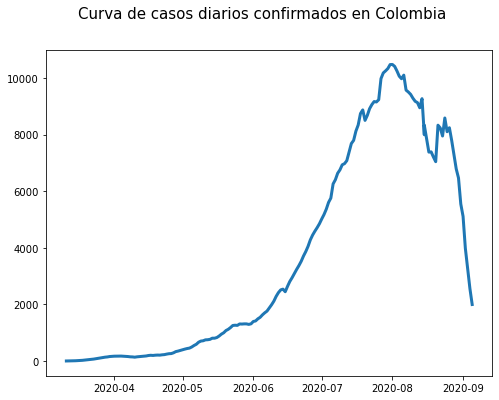

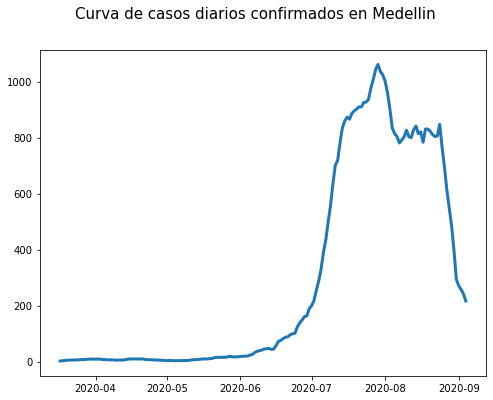

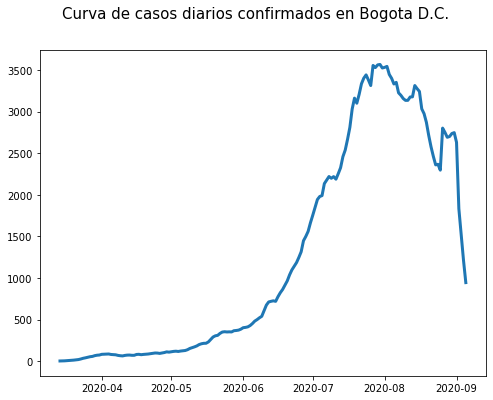

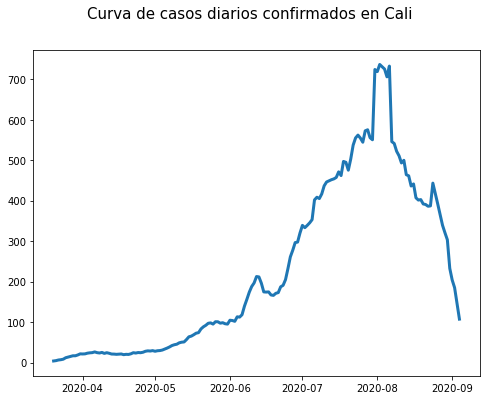

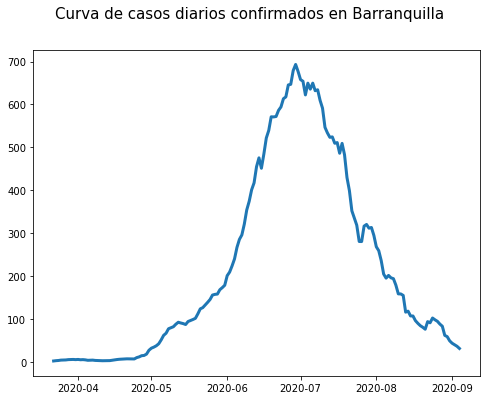

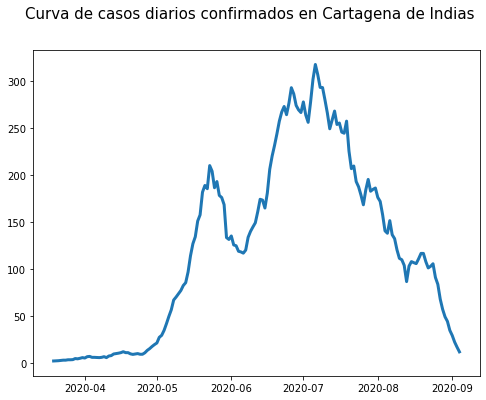

In [30]:
#Las graficas quedan guardas en la ruta "figuras/curva_casos/"
dic_tablas = {'Colombia':df_colombia,'Medellin':df_medellin,'Bogota D.C.':df_bogota,'Cali':df_cali,
              'Barranquilla':df_barranquilla,'Cartagena de Indias':df_cartagena}
for k,v in dic_tablas.items():
    fig, ax = plt.subplots(1, figsize=(8, 6))
    fig.suptitle('Curva de casos diarios confirmados en ' + str(k), fontsize=15)
    ax.plot(v['fecha'],v['infectados'], linewidth=3)
    fig = plt.savefig('figuras/curva_casos/' + 'casos_' + str(k) + '.png')